### 0. Imports and setup

In [56]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import to_hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm
from matplotlib.colors import rgb2hex



import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [43]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [44]:
BATCH_SIZE = 16

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 5 or i > 10:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

def binarize(im):
    return (im > im.max() / 2).to(im.dtype)

TRANSFORM_3D = transforms.Compose([
    # transforms.Resize(16),
    transforms.ToTensor(),
    # binarize,
    # random_color,
    # Add_dimension,
])

# Load train datasets
# mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

x_train_a = np.load(file='./data/x_train_a_c.npy')
mnist_train_a = Colored3DMNIST(x_train_a)

# indices = mnist_train_a.targets == 3
# mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


# mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)
x_train_b = np.load(file='./data/x_train_b_c.npy')
mnist_train_b = Colored3DMNIST(x_train_a)

# indices = mnist_train_b.targets == 5
# mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)
x_test = np.load(file='./data/x_test_c.npy')
mnist_test = Colored3DMNIST(x_test)

# indices = mnist_test.targets == 3
# mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [66]:
next(iter(mnist_loader_a)).shape

torch.Size([16, 3, 16, 16, 16])

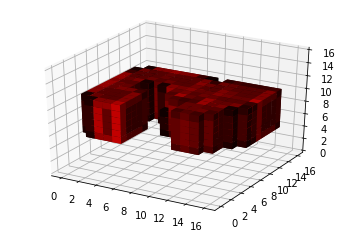

In [67]:
# def plot_img(img):
#     fig = plt.figure()
#     ax = plt.axes(projection="3d")
    
#     ax.voxels(img[0])
#     plt.show()
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    plt.show()


plot_img(next(iter(mnist_loader_test))[0])

### 3. Preparation for the training

In [68]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [69]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [70]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)

In [71]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [72]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

In [73]:
device="cuda:0"

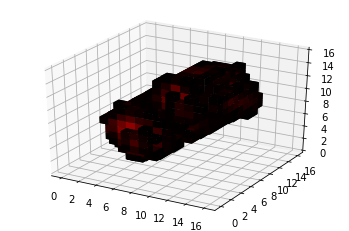

  0%|          | 0/5001 [00:00<?, ?it/s]

T_loss: 0.15762485563755035;  f_loss: 0.003976099193096161


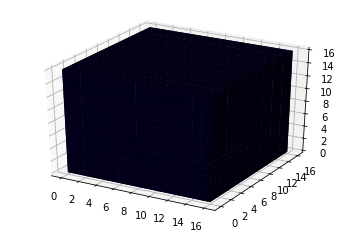

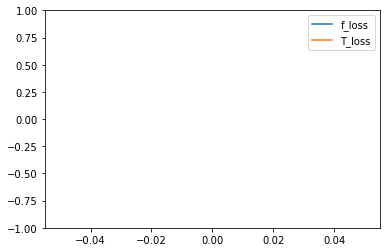

  2%|▏         | 100/5001 [00:54<43:10,  1.89it/s]

T_loss: 0.7021053433418274;  f_loss: 0.16685622930526733


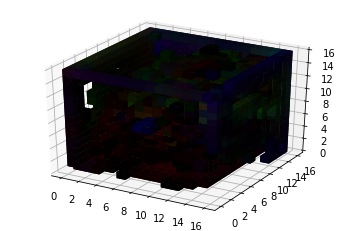

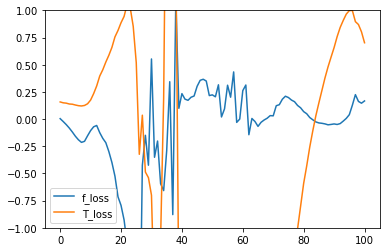

  4%|▍         | 200/5001 [01:48<42:10,  1.90it/s]  

T_loss: 58.82633590698242;  f_loss: -5.75555419921875


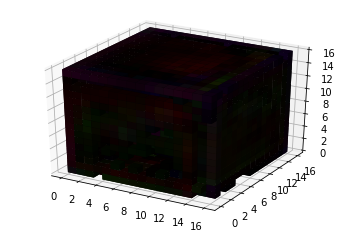

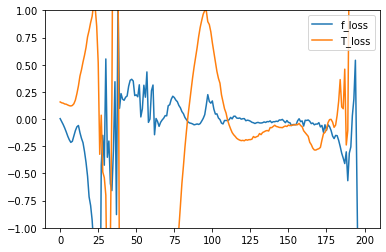

  6%|▌         | 300/5001 [02:43<41:01,  1.91it/s]  

T_loss: -432.6594543457031;  f_loss: 41.9964599609375


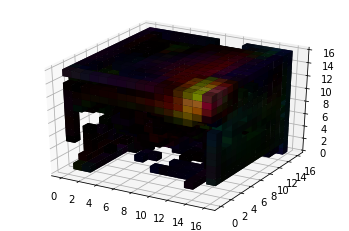

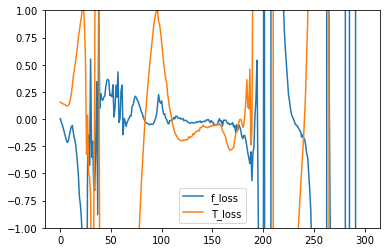

  8%|▊         | 400/5001 [03:37<40:31,  1.89it/s]  

T_loss: -118.4600601196289;  f_loss: 16.2655029296875


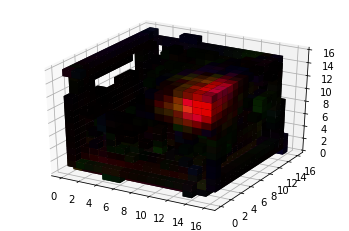

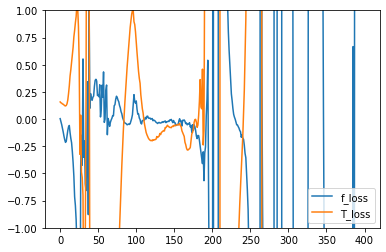

 10%|▉         | 500/5001 [04:32<39:32,  1.90it/s]  

T_loss: 6.6153154373168945;  f_loss: 0.5232810974121094


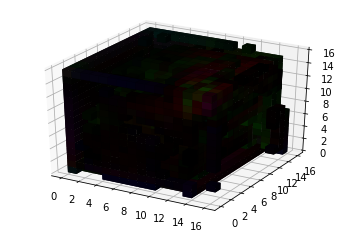

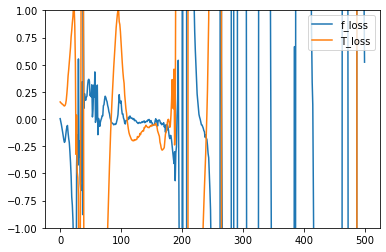

 12%|█▏        | 600/5001 [05:26<38:28,  1.91it/s]  

T_loss: -7.962779521942139;  f_loss: -3.780064582824707


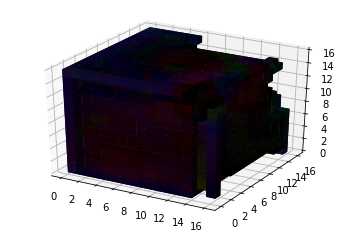

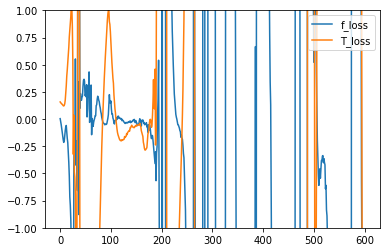

 14%|█▍        | 700/5001 [06:21<38:06,  1.88it/s]  

T_loss: -0.10967608541250229;  f_loss: -8.179760932922363


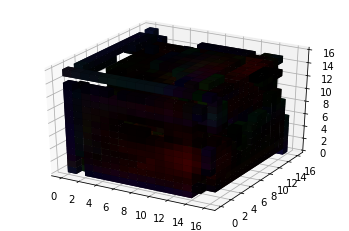

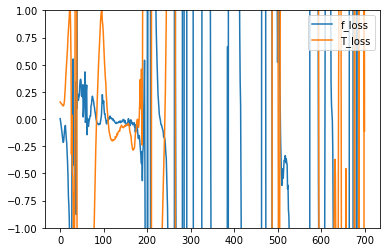

 16%|█▌        | 800/5001 [07:15<37:06,  1.89it/s]  

T_loss: -4.836326599121094;  f_loss: -9.216691017150879


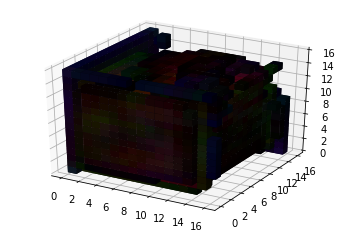

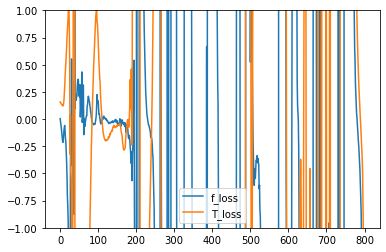

 18%|█▊        | 900/5001 [08:10<36:07,  1.89it/s]  

T_loss: 17.23382568359375;  f_loss: 2.4040603637695312


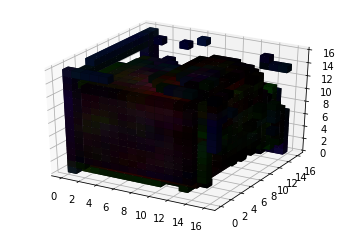

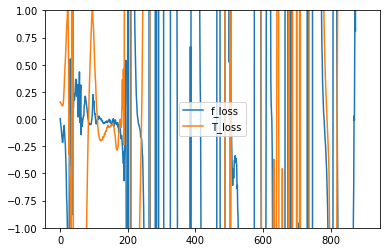

 20%|█▉        | 1000/5001 [09:04<35:24,  1.88it/s] 

T_loss: 10.67902946472168;  f_loss: 0.40439605712890625


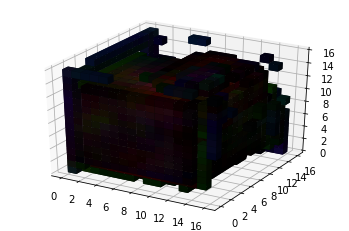

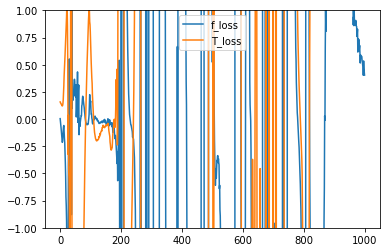

 22%|██▏       | 1100/5001 [09:58<34:27,  1.89it/s]  

T_loss: 11.023139953613281;  f_loss: -0.932464599609375


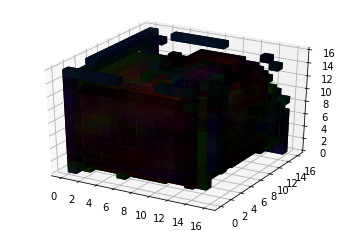

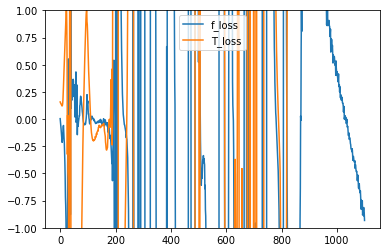

 24%|██▍       | 1200/5001 [10:53<33:21,  1.90it/s]  

T_loss: 21.97884178161621;  f_loss: -4.5255584716796875


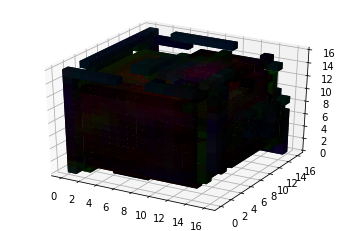

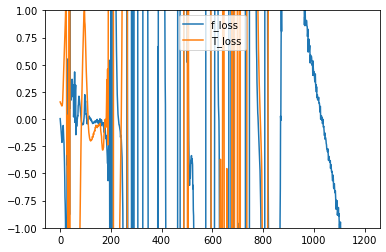

 26%|██▌       | 1300/5001 [11:47<32:46,  1.88it/s]  

T_loss: 48.340362548828125;  f_loss: -0.8683013916015625


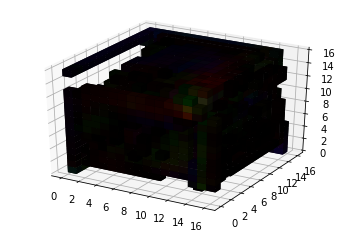

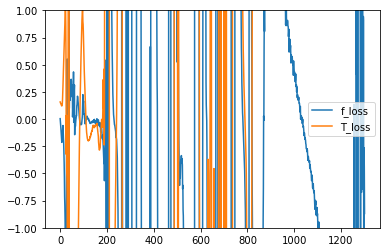

 28%|██▊       | 1400/5001 [12:42<31:54,  1.88it/s]  

T_loss: 179.91624450683594;  f_loss: -8.360275268554688


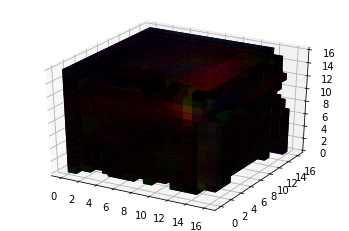

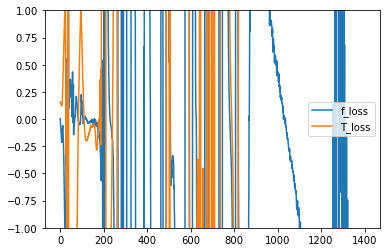

 30%|██▉       | 1500/5001 [13:37<30:44,  1.90it/s]  

T_loss: 103.20518493652344;  f_loss: -10.049629211425781


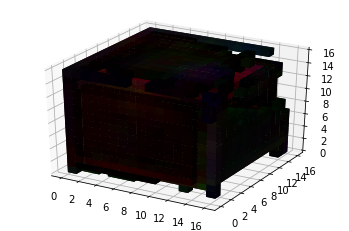

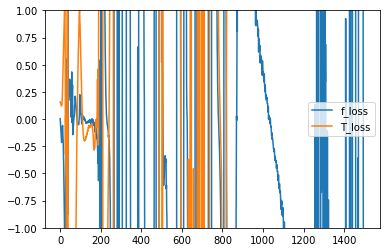

 32%|███▏      | 1600/5001 [14:31<30:05,  1.88it/s]  

T_loss: 138.84112548828125;  f_loss: -3.447601318359375


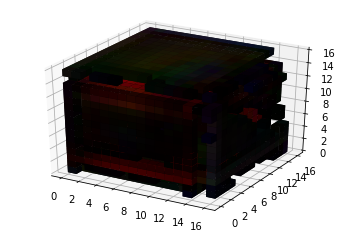

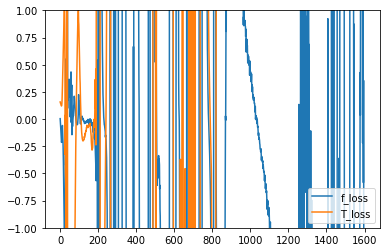

 34%|███▍      | 1700/5001 [15:26<29:08,  1.89it/s]  

T_loss: 504.26947021484375;  f_loss: -48.349945068359375


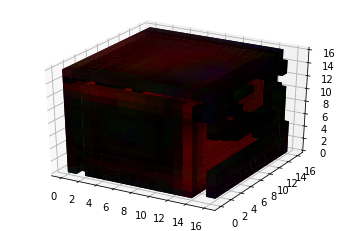

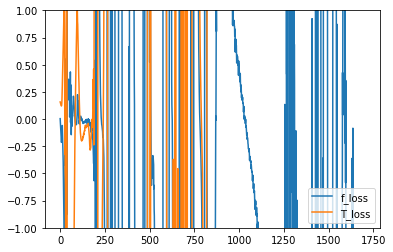

 36%|███▌      | 1800/5001 [16:22<28:01,  1.90it/s]  

T_loss: 137.6197967529297;  f_loss: 1.784759521484375


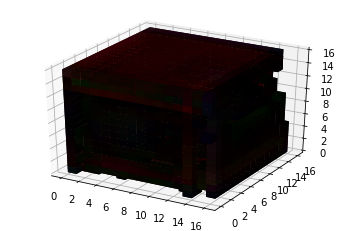

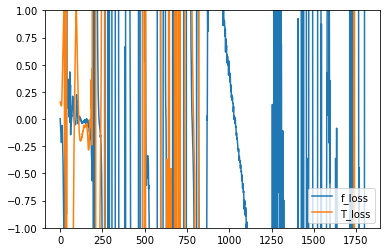

 38%|███▊      | 1900/5001 [17:17<27:26,  1.88it/s]

T_loss: 261.4990539550781;  f_loss: -8.17059326171875


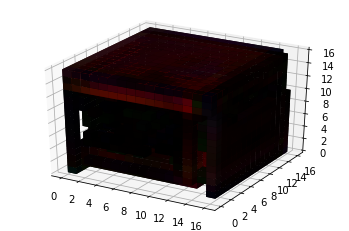

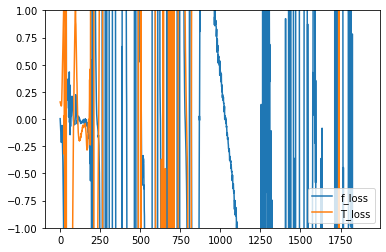

 40%|███▉      | 2000/5001 [18:12<26:30,  1.89it/s]  

T_loss: 1.3116670846939087;  f_loss: 0.48351216316223145


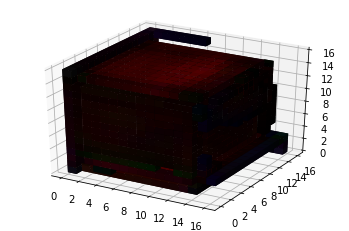

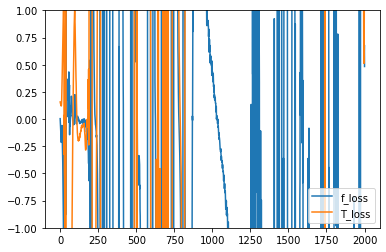

 42%|████▏     | 2100/5001 [19:06<25:31,  1.89it/s]

T_loss: -10.922789573669434;  f_loss: 0.9872903823852539


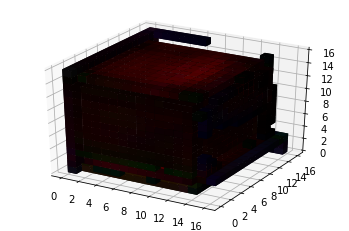

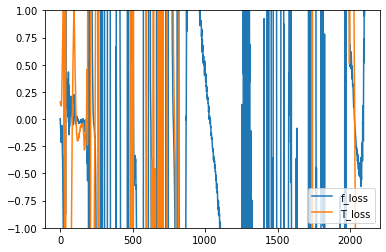

 44%|████▍     | 2200/5001 [20:01<24:54,  1.87it/s]

T_loss: 2.384047031402588;  f_loss: 0.6529026031494141


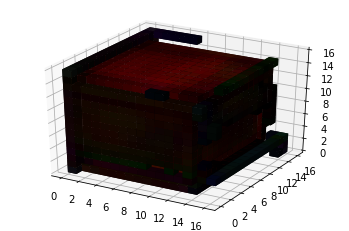

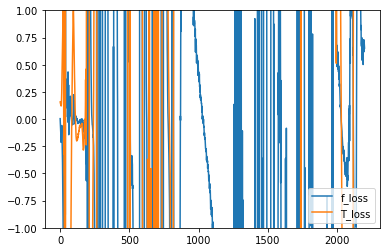

 46%|████▌     | 2300/5001 [20:55<23:49,  1.89it/s]

T_loss: 151.8443603515625;  f_loss: -17.467636108398438


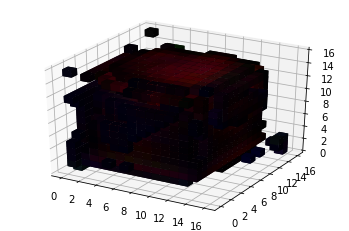

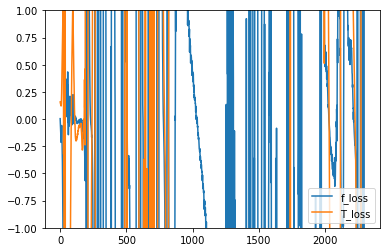

 48%|████▊     | 2400/5001 [21:49<22:52,  1.90it/s]

T_loss: 86.99565124511719;  f_loss: -4.600028991699219


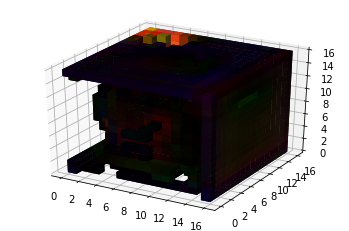

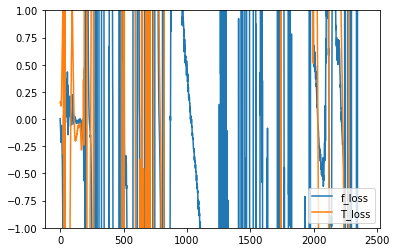

 50%|████▉     | 2500/5001 [22:44<22:12,  1.88it/s]

T_loss: 20.211198806762695;  f_loss: 6.927019119262695


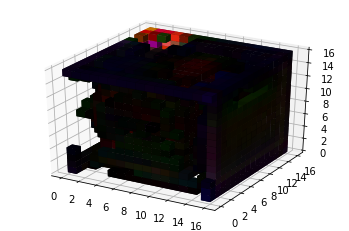

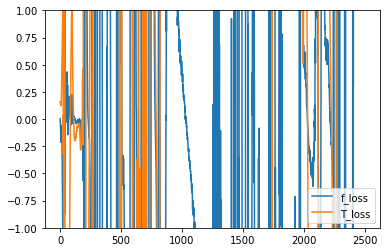

 52%|█████▏    | 2600/5001 [23:39<21:13,  1.88it/s]

T_loss: 10.018436431884766;  f_loss: 2.8447723388671875


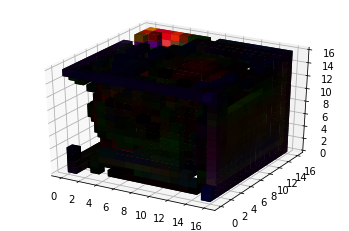

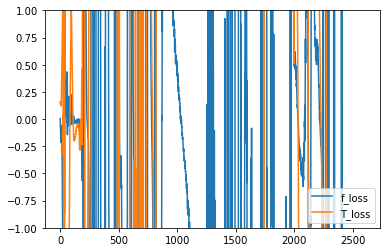

 54%|█████▍    | 2700/5001 [24:34<20:16,  1.89it/s]

T_loss: 4.654423713684082;  f_loss: 0.7477002143859863


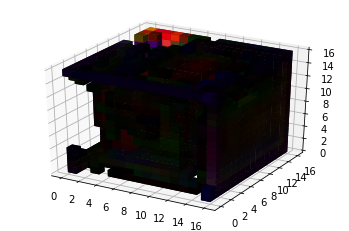

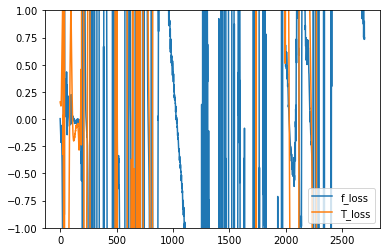

 56%|█████▌    | 2800/5001 [25:28<19:29,  1.88it/s]

T_loss: 1.95573890209198;  f_loss: -0.09029459953308105


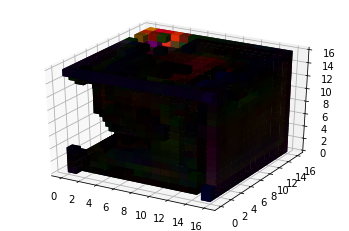

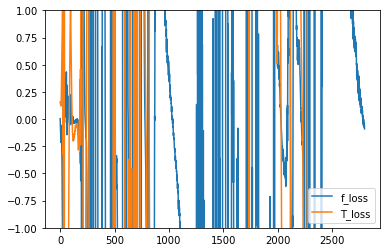

 58%|█████▊    | 2900/5001 [26:23<18:37,  1.88it/s]

T_loss: 1.6928869485855103;  f_loss: -0.40678179264068604


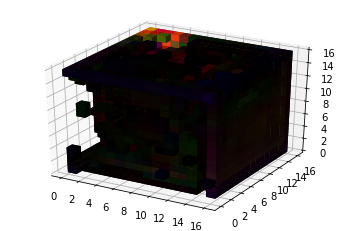

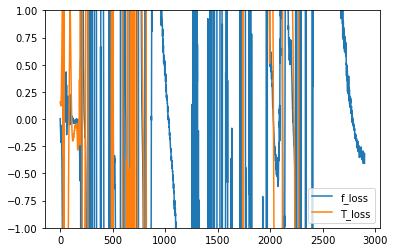

 60%|█████▉    | 3000/5001 [27:18<17:38,  1.89it/s]

T_loss: 11.078661918640137;  f_loss: 1.7193489074707031


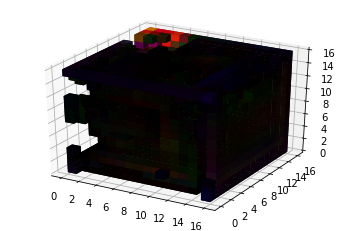

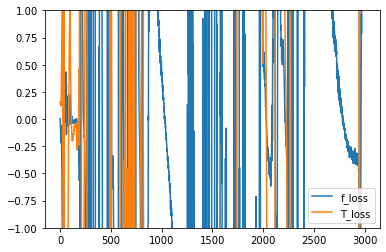

 62%|██████▏   | 3100/5001 [28:13<16:30,  1.92it/s]

T_loss: 2.632852792739868;  f_loss: -0.2062056064605713


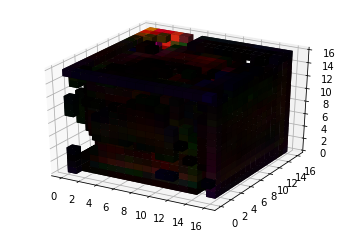

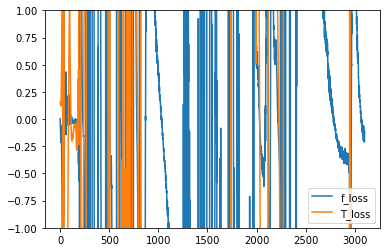

 64%|██████▍   | 3200/5001 [29:08<15:56,  1.88it/s]

T_loss: 3.0027289390563965;  f_loss: -0.3801307678222656


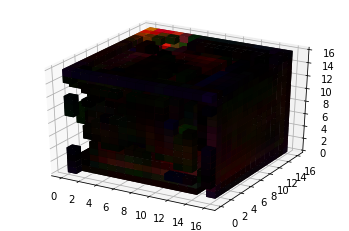

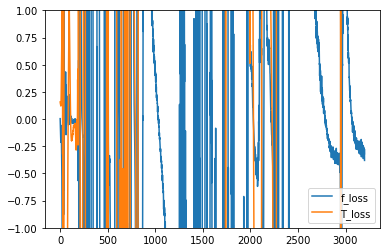

 66%|██████▌   | 3300/5001 [30:03<15:01,  1.89it/s]

T_loss: 3.520827293395996;  f_loss: -0.42247605323791504


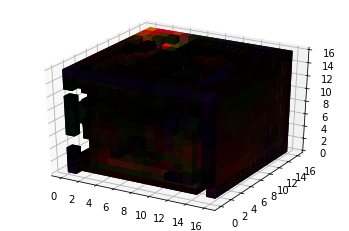

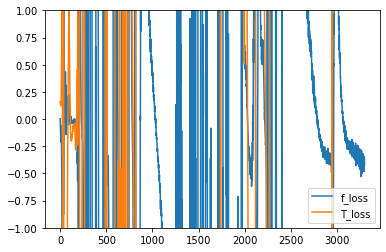

 68%|██████▊   | 3400/5001 [30:58<14:01,  1.90it/s]

T_loss: 3.950002908706665;  f_loss: -0.4483628273010254


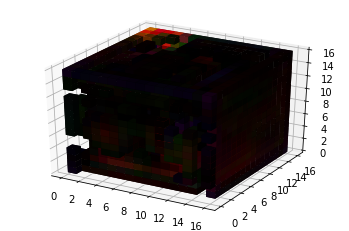

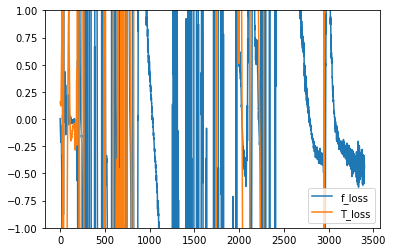

 70%|██████▉   | 3500/5001 [31:53<13:16,  1.88it/s]

T_loss: 4.42252254486084;  f_loss: -0.4059290885925293


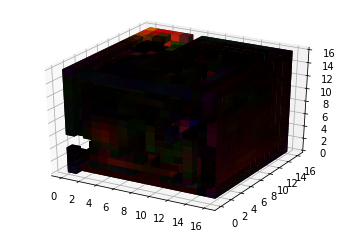

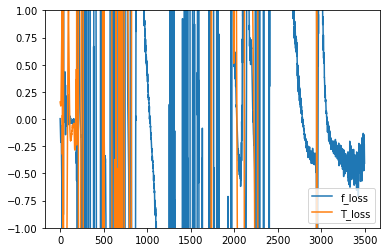

 72%|███████▏  | 3600/5001 [32:48<12:21,  1.89it/s]

T_loss: 4.914967060089111;  f_loss: 0.07886648178100586


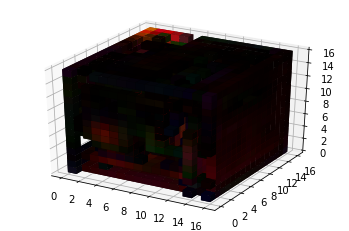

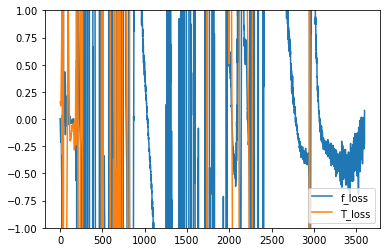

 74%|███████▍  | 3700/5001 [33:44<11:22,  1.91it/s]

T_loss: 5.883427143096924;  f_loss: -0.16916990280151367


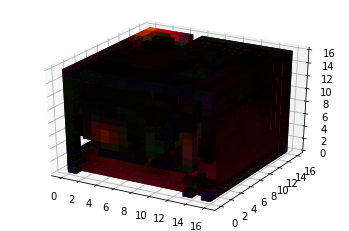

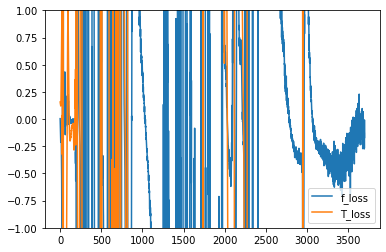

 76%|███████▌  | 3800/5001 [34:39<10:37,  1.88it/s]

T_loss: 7.484858989715576;  f_loss: -0.3320465087890625


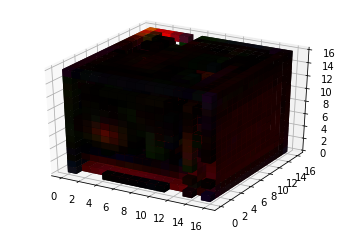

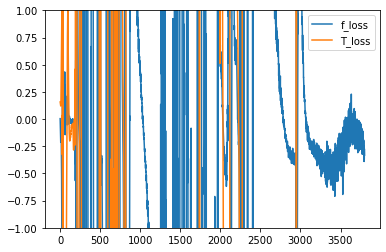

 78%|███████▊  | 3900/5001 [35:35<10:47,  1.70it/s]

T_loss: 8.731077194213867;  f_loss: -0.6350135803222656


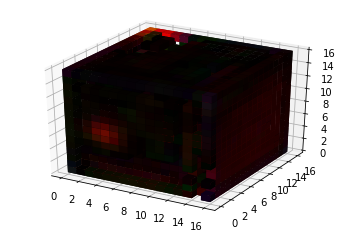

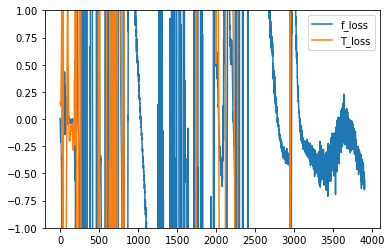

 80%|███████▉  | 4000/5001 [36:31<08:50,  1.89it/s]

T_loss: 9.203302383422852;  f_loss: -0.43984031677246094


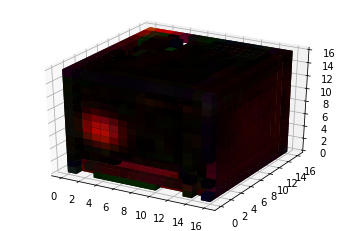

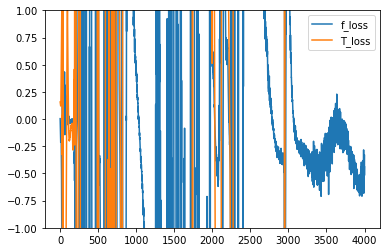

 82%|████████▏ | 4100/5001 [37:27<07:59,  1.88it/s]

T_loss: 9.262284278869629;  f_loss: -0.48702144622802734


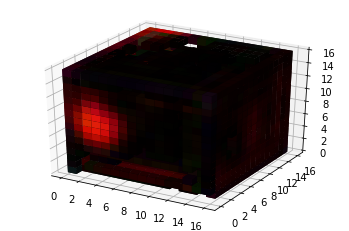

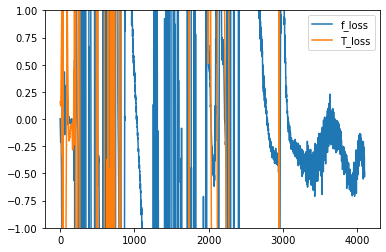

 84%|████████▍ | 4200/5001 [38:22<07:04,  1.89it/s]

T_loss: 8.072364807128906;  f_loss: -0.28148889541625977


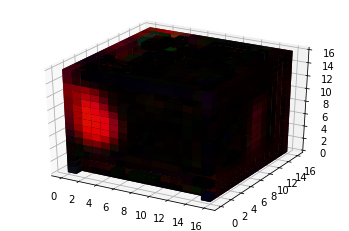

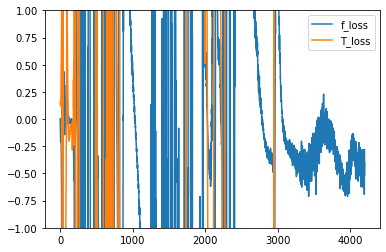

 86%|████████▌ | 4300/5001 [39:18<06:10,  1.89it/s]

T_loss: 6.703943252563477;  f_loss: -0.05855751037597656


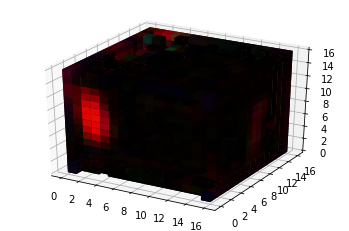

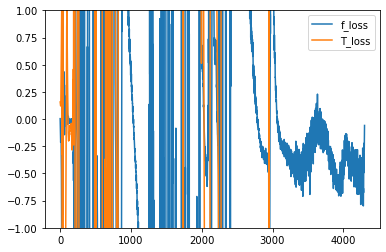

 88%|████████▊ | 4400/5001 [40:13<05:19,  1.88it/s]

T_loss: 9.208581924438477;  f_loss: -0.11236190795898438


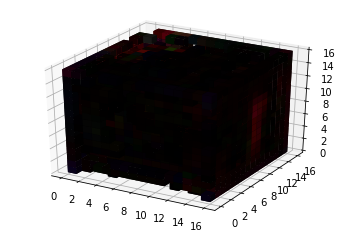

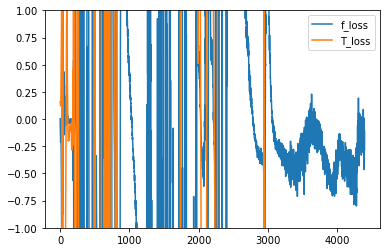

 90%|████████▉ | 4500/5001 [41:09<04:27,  1.87it/s]

T_loss: 6.654904365539551;  f_loss: -0.42388486862182617


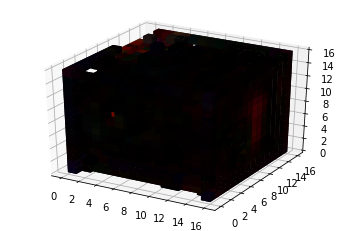

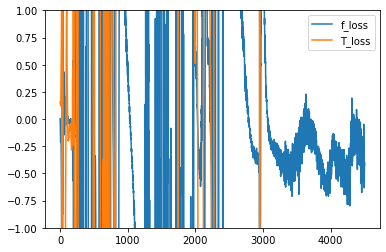

 92%|█████████▏| 4600/5001 [42:04<03:31,  1.90it/s]

T_loss: 0.073865607380867;  f_loss: -0.019829489290714264


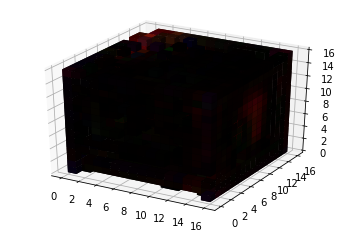

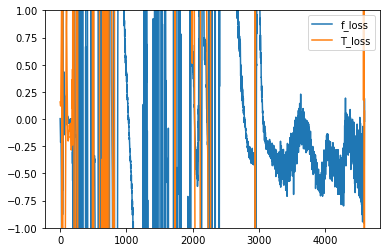

 94%|█████████▍| 4700/5001 [43:00<02:39,  1.88it/s]

T_loss: 39.30207824707031;  f_loss: 0.5860099792480469


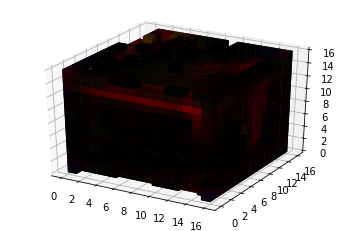

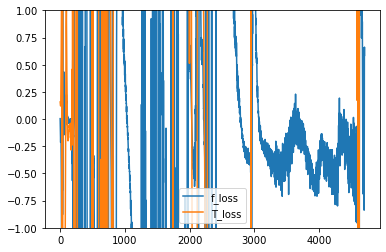

 96%|█████████▌| 4800/5001 [43:55<01:47,  1.88it/s]

T_loss: 37.876705169677734;  f_loss: 0.1696624755859375


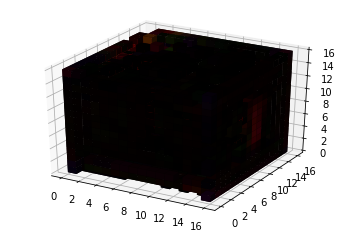

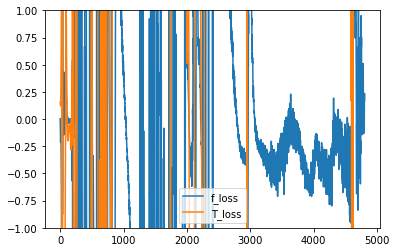

 98%|█████████▊| 4900/5001 [44:51<00:53,  1.89it/s]

T_loss: 34.421844482421875;  f_loss: -0.15990066528320312


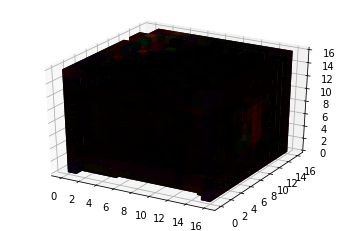

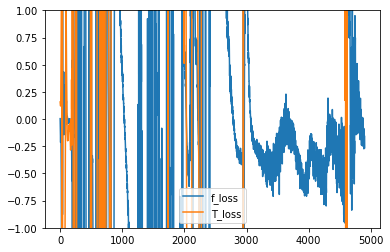

100%|█████████▉| 5000/5001 [45:46<00:00,  1.88it/s]

T_loss: 34.9665412902832;  f_loss: -0.4883575439453125


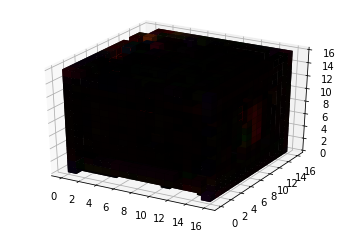

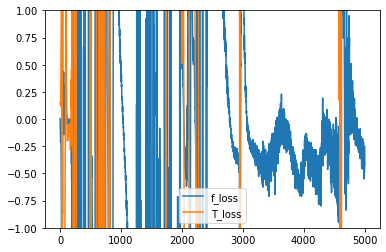

100%|██████████| 5001/5001 [45:50<00:00,  1.82it/s]


In [74]:
test_sample = sample_test().to(device=device, dtype=torch.float)
plot_img(test_sample[0].cpu())
T_losses = []
f_losses = []

for step in tqdm(range(5001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(5):
        X = sample_train_a().to(device=device, dtype=torch.float)

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    
    T_losses.append(T_loss.cpu().detach().numpy())

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().to(device=device, dtype=torch.float)
    Y = sample_train_b().to(device=device, dtype=torch.float)

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    f_losses.append(f_loss.cpu().detach().numpy())

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_sample)[0].cpu().detach(), min=0, max=1)
        plot_img(T_X)

        plt.plot(np.arange(len(f_losses)), f_losses, label="f_loss")
        plt.plot(np.arange(len(T_losses)), T_losses, label="T_loss")

        plt.ylim(-1, 1)
        plt.legend()
        plt.show()

    # Save OT map every 1000 steps
    if not step % 1000:
        torch.save(T.state_dict, f"weights/OT_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [95]:
test_sample = sample_test().to(device=device, dtype=torch.float)


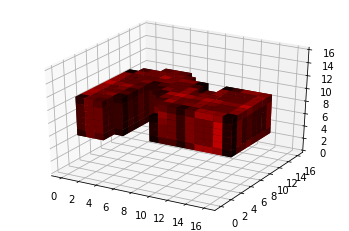

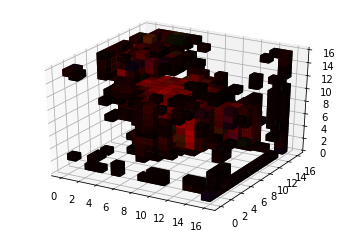

In [99]:
sample_n = 6
plot_img(test_sample[sample_n].cpu())

T_Y = torch.clip(T(test_sample)[sample_n].cpu().detach(), min=0, max=1)
T_Y[T_Y < np.quantile(T_Y, 0.91)] = 0
plot_img(T_Y)